# Building the upsampling dataset

To ensure smooth training, we need the text that represents well all the phonemes, including the rare ones. So, we need some efforts to generate the text with this kind of representation.

One of the processing steps is to convert sentences to transcriptions with ESpeak. Let's ensure BrainBox is running and the decider is installed.

In [1]:
from brainbox import BrainBox
from brainbox.deciders import EspeakPhonemizer

api = BrainBox.Api('127.0.0.1:8090')
api.controller_api.install_if_not_installed(EspeakPhonemizer)

To start, we need a large amount of texts in the language of choice. The texts should not be scientific: Wikipedia and alike doesn't work, because it contains a lot of words with custom pronounciation that the model is not guaranteed to grasp. Newspapers are OK, the best is the novels with local character's names and places. 

In this demo we use small sample from https://huggingface.co/datasets/NickyNicky/global-news-dataset . 

In [2]:
from yo_fluq import FileIO

raw_text = FileIO.read_json('../files/sample.json')
raw_text[0][:400]

'UN Secretary-General Antonio Guterres urged the world Monday to "stop the madness" of climate change as he visited Himalayan regions struggling from rapidly melting glaciers to witness the devastating impact of the phenomenon. "The rooftops of the world are caving in," Guterres said on a visit to the Everest region in mountainous Nepal, adding that the country had lost nearly a third of its ice in'

First class that we need in `Language`. This class describes the symbols that can occure within the words and sentences, typical typographic transformations that happen in different languages (e.g. `"` can be `»` in German and `“` in English), etc.

We create `UpsamplingDatasetBuilder`, the class that contains all the requied functionality. It creates a temporary files in the process, if you care where they are, provide the path in ctor. Also, you need to have BrainBox running with `EspeakPhonemizer` installed.

In [3]:
from pathlib import Path
from chara.voice_clone.sentences import *
from chara.tools import Language

folder = Path('temp/builder')
language = Language.English()
builder = UpsamplingDatasetBuilder('demo', language, folder)
builder.locations.reset()

## Filtering

The first stage in the process is to filter out the bad sentences from the source text. There are a lot of reasons the sentence may be considered "bad", and the main ones are listed here:

In [4]:
builder.filters = [
    BadSymbolsFilter.from_language(language),
    LengthFilter(80,100),
    TooMuchCapitalLettersFilter(4),
    NoAbbreviationsFilter.from_language(language),
]

Length from 80 to 100 is, in my opinion, optimal: sentences <80 won't allow the voice to experience all the variations, while too long sentences often guide the upsampling to hallucinations.

TooMuchCapitalLetters are important to remove the sentences with lots of names: these names are often foreign and thus do not really reflect the pronounciation of the language, so you don't really want to train your model on them (for modifications required for German language, see the end of the notebook).

An additional filter you may want to employ is a filter that only keeps the words from certain disctionary. E.g. a Vosk dictionary: we are going to push every voiceover in upsampling through the voice recognition with VOSK, so the sentences with the words outside of the dictionary don't really have chances to be recognized. To do the filtration:

In [5]:
from brainbox.framework import Loc


vosk_dictionary_path = Path('temp/vosk_dictionary.json')
if not vosk_dictionary_path.is_file():
    dict_file = Loc.resources_folder/'Vosk/models/en/graph/words.txt'
    words = DictionaryFilter.process_vosk_dictionary(dict_file, language.standardizer)
    FileIO.write_json(list(words),vosk_dictionary_path)

builder.filters.append(DictionaryFilter(language.standardizer, FileIO.read_json(vosk_dictionary_path)))

Now we can filter the dataset and store the result of this stage.

In [6]:
builder.create_source_text(raw_text)
source = FileIO.read_json(builder.locations.source)
assert len(source)>10
source[:3]

  0%|          | 0/50 [00:00<?, ?it/s]

["In the first phase of climate change's effects, melting glaciers can trigger destructive floods.",
 'The Northeast has a key place in the hydel power push of successive governments at the Centre.',
 'He said his government is sending humanitarian assistance for the besieged residents of Gaza.']

## Phonemization

Next, we need to convert all the sentences to phonemes. That is done with the help of BrainBox

In [7]:
import pprint

command = builder.create_phonemize_command()
phonemization = command.execute(api)
print(pprint.pformat(phonemization[:1])[:300])

[{'error': None,
  'id': 'id_cfe809decf1f4b7f934b17dcda8511dd',
  'result': [[['ɪ', 'n', 'ð', 'ə'],
              ['f', 'ɜː', 's', 't'],
              ['f', 'eɪ', 'z'],
              ['ʌ', 'v'],
              ['k', 'l', 'aɪ', 'm', 'ə', 't'],
              ['tʃ', 'eɪ', 'n', 'dʒ', 'ᵻ', 'z'],
         


At this point, for a new language, we can also view all the phonemes with their frequency. This is a good way to distinguish the phonemes that are native to this language and the phonemes that came from the foreign words, like e.g. "Chance" is pronounced in German with nasal a). 

In [8]:
data = builder.preprocess_phonemization_samples_data()
builder.create_phonemization_samples(data).head()

,phoneme,count,0,1,2,3,4
0,t,74,"(traffic, t ɹ æ f ɪ k)","(set, s ɛ t)","(bankruptcy, b æ ŋ k ɹ ʌ p t s i )","(rat, ɹ æ t)","(trend, t ɹ ɛ n d)"
1,s,72,"(say, s eɪ)","(sirens, s aɪ ɹ ə n z)","(set, s ɛ t)","(bankruptcy, b æ ŋ k ɹ ʌ p t s i )","(bust, b ʌ s t)"
2,n,64,"(sirens, s aɪ ɹ ə n z)","(Zealand, z iː l ə n d )","(in, ɪ n)","(trend, t ɹ ɛ n d)","(benches, b ɛ n tʃ ᵻ z)"
3,ɪ,57,"(traffic, t ɹ æ f ɪ k)","(in, ɪ n)","(being, b iː ɪ ŋ)","(economy, ɪ k ɑː n ə m i)","(smuggling, s m ʌ ɡ l ɪ ŋ)"
4,ɹ,46,"(sirens, s aɪ ɹ ə n z)","(traffic, t ɹ æ f ɪ k)","(bankruptcy, b æ ŋ k ɹ ʌ p t s i )","(re, ɹ iː)","(rat, ɹ æ t)"


Then, the phonemes are postprocessed, so for each sentence it is indicated how many time each phoneme has occured in this sentence

In [9]:
builder.postprocess_phonemization()
phonemization = FileIO.read_json(builder.locations.phonemized_dataset)
assert len(phonemization)==len(source)
phonemization[list(phonemization)[0]]

{'sentence': "In the first phase of climate change's effects, melting glaciers can trigger destructive floods.",
 'stats': {'ɪ': 5,
  'n': 3,
  'ð': 1,
  'ə': 2,
  'f': 4,
  'ɜː': 1,
  's': 3,
  't': 7,
  'eɪ': 3,
  'z': 4,
  'ʌ': 3,
  'v': 2,
  'k': 4,
  'l': 4,
  'aɪ': 1,
  'm': 2,
  'tʃ': 1,
  'dʒ': 1,
  'ᵻ': 2,
  'ɛ': 2,
  'ŋ': 1,
  'ɡ': 2,
  'ʃ': 1,
  'ɚ': 2,
  'æ': 1,
  'ɹ': 2,
  'd': 2}}

## Algorithm

Now, we can run the algorithm that will select the sentences.

In [10]:
import os

builder.target_sentence_count = 20
result = builder.run_algorithm()

os.makedirs('temp', exist_ok = True)
UpsamplingDatasetBuilder.write(result, 'temp/output.txt')

0 id_136d5e5f0c8d4ed0dc3e3fca: The reasons for launching the program specifically in New Zealand and the Philippines are unclear.
1 id_6e29915dc6ddca03f6879688: Then they wait on another set of outdoor benches after clearing the security check.
2 id_2f30c620c7a92c22a00e9e0e: It is the same stocks that we are holding and buying more of, which I have spoken about many times.
3 id_f850996d585db7bf3eb16aad: Observers say talks are the only way forward because both nuclear-armed countries have much to lose.
4 id_abf43a3c0468c3e40c24c8d8: Notably, it is the first time that Germany has signed such a bilateral agreement.
5 id_61d87b46dbd1c2c6b44d6ede: One woman was missing after being engulfed by a landslide triggered by the quake, he said.
6 id_452d045f715323354ca86174: Also, valuation-wise, it is amazingly cheap compared to most of the other banking stocks.
7 id_f6256fca3f8118c281d8d479: Gymnastics gave her superior body awareness, while competing in triathlons built up her endurance.
8 id_f

The following plot is very helpful to evaluate the result. Normally, it should look like steps: every 3-7 iterations of the algorithm, the minimal representation among each phonemes is increased by 1. Since we have a very small dataset, only one "step" in this staircase is achieved.

<Axes: >

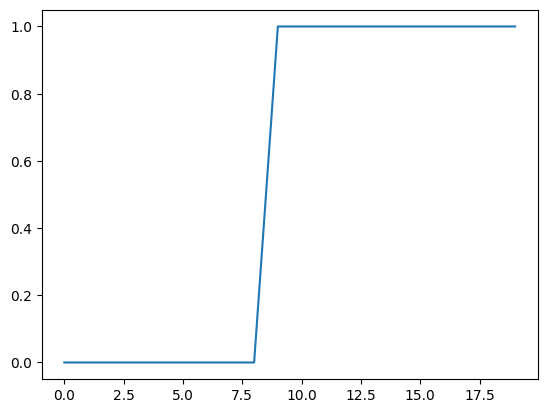

In [11]:
builder.get_statistics_frame(result).cumsum().min(axis=1).plot()

The output of the algorithm may need further review: when taking data from real datasets, it's sometimes full with rubbish. To do the reviwew, I usually copy text from the notebook and paste into the file. When removing sentence completely, keep id: it will help to later add something to the dataset, you will be able to exclude sentences from the algorithm's scope. After this, the sentences can be extracted from the file with:

In [12]:
UpsamplingDatasetBuilder.get_sentences_from_file('temp/output.txt')

['The reasons for launching the program specifically in New Zealand and the Philippines are unclear.',
 'Then they wait on another set of outdoor benches after clearing the security check.',
 'It is the same stocks that we are holding and buying more of, which I have spoken about many times.',
 'Observers say talks are the only way forward because both nuclear-armed countries have much to lose.',
 'Notably, it is the first time that Germany has signed such a bilateral agreement.',
 'One woman was missing after being engulfed by a landslide triggered by the quake, he said.',
 'Also, valuation-wise, it is amazingly cheap compared to most of the other banking stocks.',
 'Gymnastics gave her superior body awareness, while competing in triathlons built up her endurance.',
 'The latest results, which Duggan says come as a surprise, point to a reversal of this trend.',
 'Violent torrents struck Sikkim state on Wednesday after a high-altitude glacial lake suddenly burst.',
 'In the United Stat

# Notes for German language

For German language, we have to go differently with the capital letters, as all the nouns are capitalized. But still, we want to exclude the words that are not native to German, and this problem is additionally aggravated by the fact that German is full of anglicisms that are pronounced in the English manner by people, but not by ESpeak. Correspondingly, there will probably be a gap between the guessed transcription and the real pronounciation, which would probably decrease the quality of the model. 

To remove these words, I used this trick: all the capitalized words from the dataset are processed with `langdetect`, and then all the words that weren't guessed to be German is removed. A lot of native words are getting removed, too, but the quality of the dataset really increased.

I will demostrate how to do it in English, although it doesn't make much sense for this language: English doesn't tolerate foreign phonemes, so it's a less of the problem

  0%|          | 0/49 [00:00<?, ?it/s]

,vi,en,pl,fi,it,nl,tr,id,pt,sw,...,cy,de,et,no,da,tl,hu,es,ro,fr
word,,,,,,,,,,,,,,,,,,,,,
Xinhua,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Back,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Violent,0.0,0.0,0.0,0.485687,0.500028,0.014286,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Germany,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Post,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


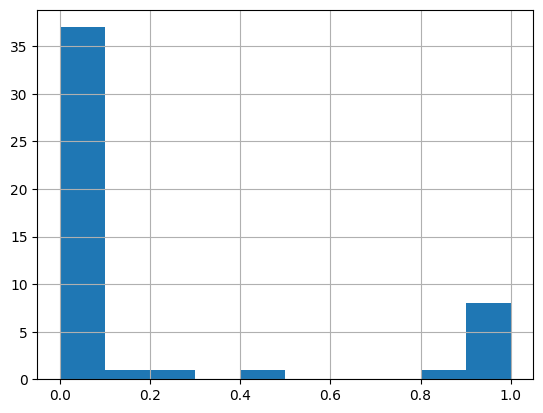

In [13]:
from chara.voice_clone.sentences import ForeignWordFixer

sentences = FileIO.read_json(builder.locations.source)
fixer = ForeignWordFixer(Language.English().standardizer)
words,_ = fixer.get_capitalized_and_not_capitalized_words(sentences)
df = fixer.get_words_statistics(words)
df.sort_values('en').en.hist()
df.loc[df.en<0.1].head()

Then, we save these words in the file, so they can be used by DictionaryFilter (with exclude option).


In [14]:
excluded_words = fixer.standardize_words(df.loc[df.en<0.2].index)
FileIO.write_json(excluded_words, 'temp/non_english.json')